In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import numpy as np

We will be looking at the following 3-SAT of 5 clauses
$$
(\neg{v_1} \lor \neg{v_2} \lor \neg{v_3}) \land (v_1 \lor \neg{v_2} \lor v_3) \land (v_1 \lor v_2 \lor \neg{v_3}) \land (v_1 \lor \neg{v_2} \lor \neg{v_3}) \land (\neg{v_1} \lor v_2 \lor v_3)
$$
with solution set
$$
(T, F, T) = 101\\
(F, F, F) = 000 \\
(T, T, F) = 110 \\
$$

In [2]:
# Define general diffuser
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [3]:
# Define quantum OR
def OR(qc, vars, out):
    # Invert all inputs
    qc.x(vars[0])
    qc.x(vars[1])
    qc.x(vars[2])

    # Computer OR
    qc.mct(vars, out)

    # Flip back to original inputs
    qc.x(vars[0])
    qc.x(vars[1])
    qc.x(vars[2])

In [4]:
# Initialize circuit
var_qubits = QuantumRegister(3, name='v')    # One qubit per variable
clause_qubits = QuantumRegister(5, name='c') # One cubit per clause
out_qubit = QuantumRegister(1, name='out')   # Used to write output of clauses
cbits = ClassicalRegister(3, name='cbits')   # Three classical bits for output

qc = QuantumCircuit(var_qubits, clause_qubits, out_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), out_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)

# Initialize clause qubits to 1 
qc.x(clause_qubits)

qc.barrier()  # for visual separation

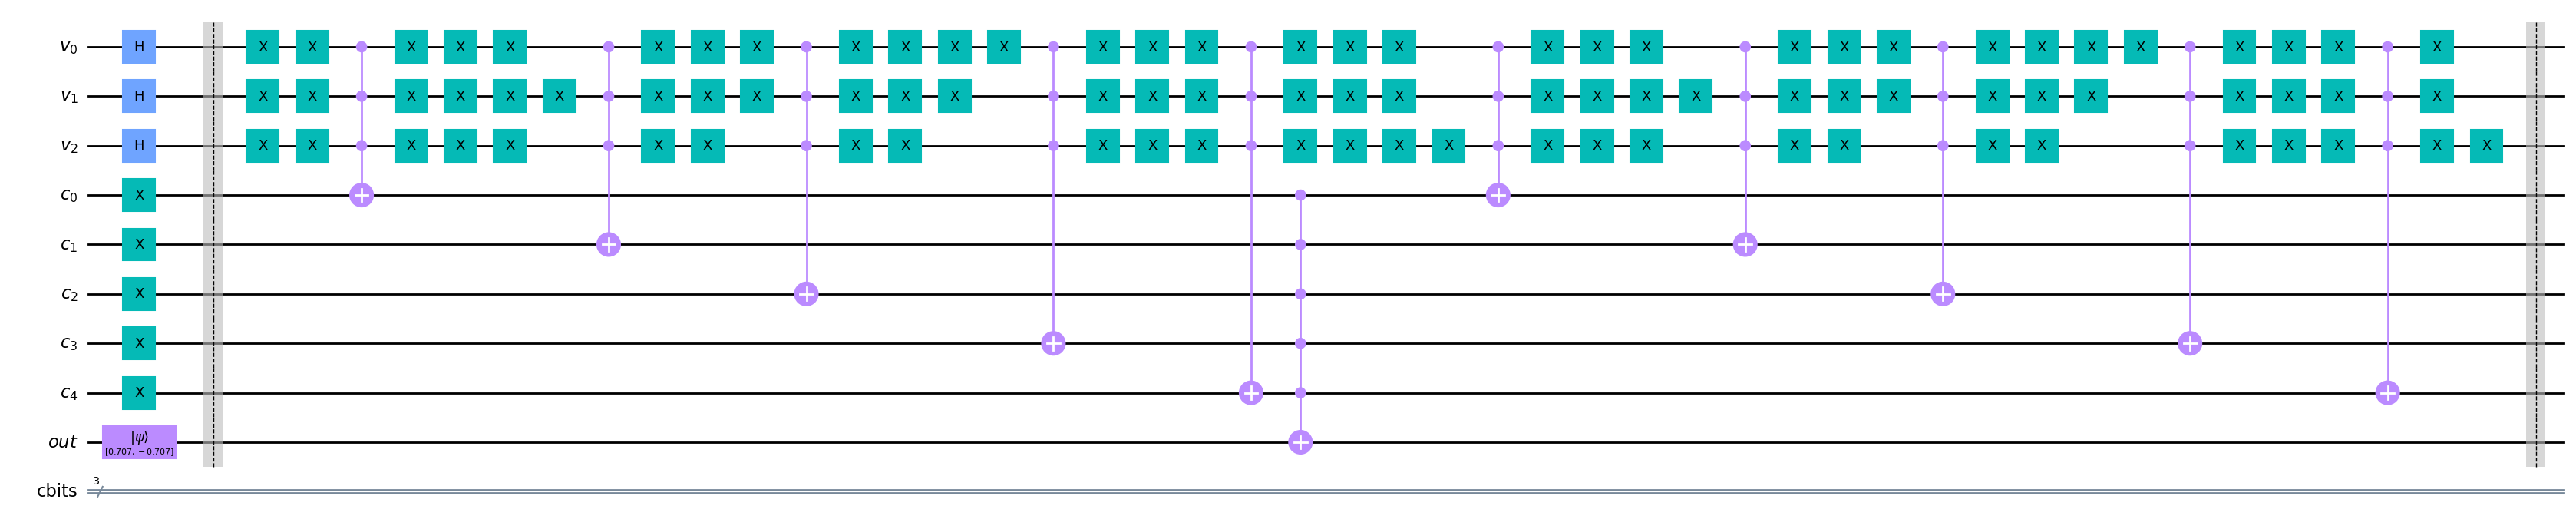

In [5]:
# REMINDER: QISKIT ORDERS QUBITS THE OPPOSITE WAY ROUND
# Add the first clause ( -v1 OR -v2 OR -v3 )
    # Apply NOT to all qubits
qc.x(var_qubits[0])
qc.x(var_qubits[1])
qc.x(var_qubits[2])

    # Add OR
OR(qc, var_qubits, clause_qubits[0])

    # Flip back
qc.x(var_qubits[0])
qc.x(var_qubits[1])
qc.x(var_qubits[2])

# Add second clause (v1 OR -v2 OR v3)
    # Flip v2
qc.x(var_qubits[1])

    # Add OR
OR(qc, var_qubits, clause_qubits[1])

    # Flip back
qc.x(var_qubits[1])

# Add third clause (v1 OR v2 OR -v3)
    # Flip v3
qc.x(var_qubits[0])

    # Add OR
OR(qc, var_qubits, clause_qubits[2])

    # Flip back
qc.x(var_qubits[0])

# Add fourth clause (v1 OR -v2 OR -v3)
    # Flip v2 and v3
qc.x(var_qubits[1])
qc.x(var_qubits[0])
    
    # Add OR
OR(qc, var_qubits, clause_qubits[3])

    # Flip back
qc.x(var_qubits[1])
qc.x(var_qubits[0])

# Add fifth clause (-v1 OR v2 OR v3)
    # Flip v1
qc.x(var_qubits[2])

    # Add OR
OR(qc, var_qubits, clause_qubits[4])

    # Flip back
qc.x(var_qubits[2])

# Flip output if all clauses are satisfied
qc.mct(clause_qubits, out_qubit)

# Uncompute clauses to reset clause-checking bits to 0
qc.x(var_qubits[0])
qc.x(var_qubits[1])
qc.x(var_qubits[2])
OR(qc, var_qubits, clause_qubits[0])
qc.x(var_qubits[0])
qc.x(var_qubits[1])
qc.x(var_qubits[2])

qc.x(var_qubits[1])
OR(qc, var_qubits, clause_qubits[1])
qc.x(var_qubits[1])

qc.x(var_qubits[0])
OR(qc, var_qubits, clause_qubits[2])
qc.x(var_qubits[0])

qc.x(var_qubits[1])
qc.x(var_qubits[0])
OR(qc, var_qubits, clause_qubits[3])
qc.x(var_qubits[1])
qc.x(var_qubits[0])

qc.x(var_qubits[2])
OR(qc, var_qubits, clause_qubits[4])
qc.x(var_qubits[2])

qc.barrier()
qc.draw(output='mpl', fold=-1)



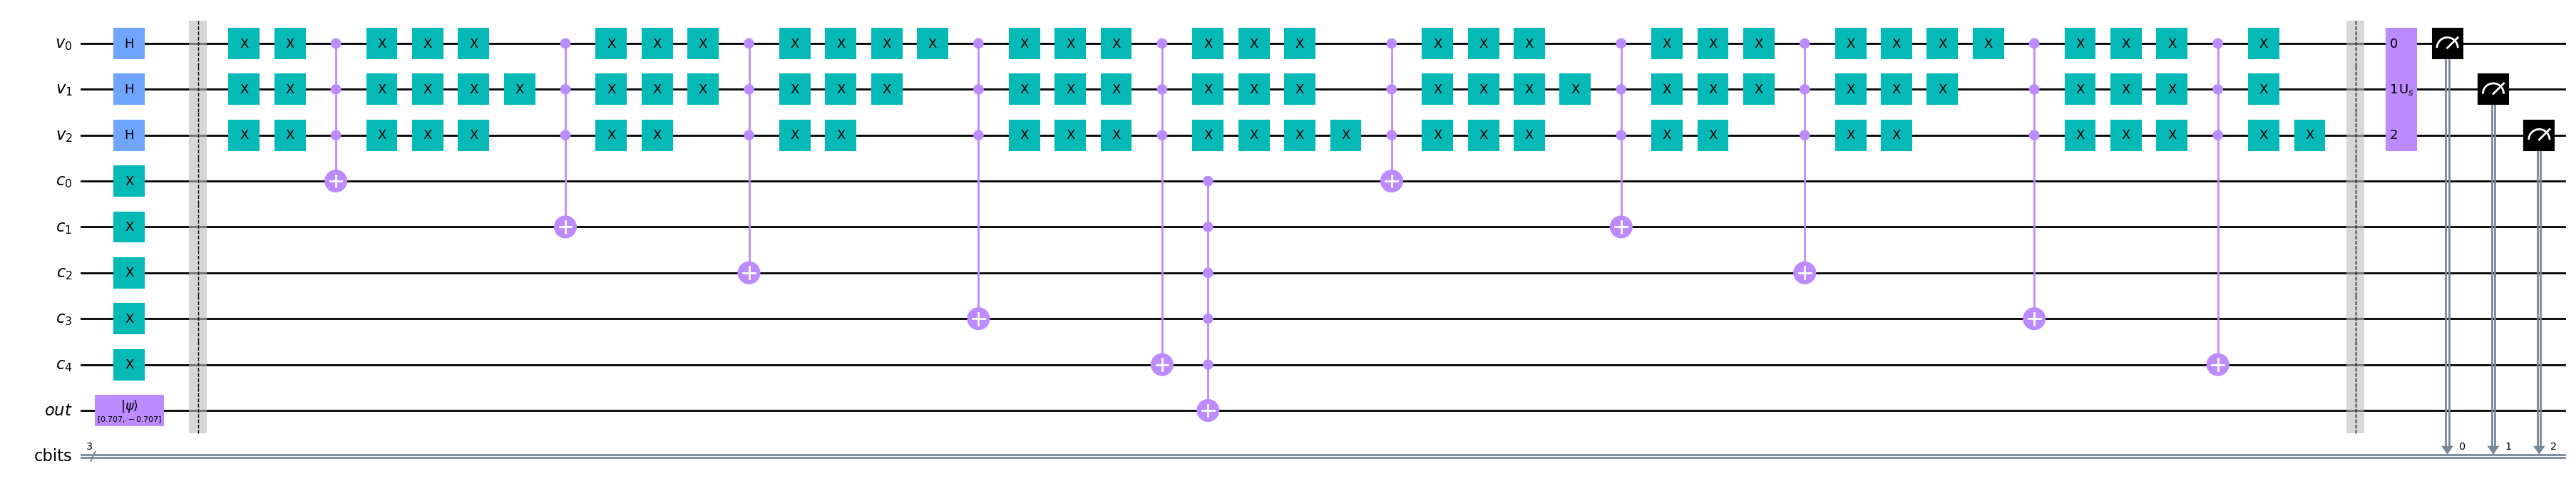

In [6]:
# Append diffuser
qc.append(diffuser(3), [0,1,2])

# Perform measurement
qc.measure(var_qubits, cbits)
qc.draw(output='mpl', fold=-1)

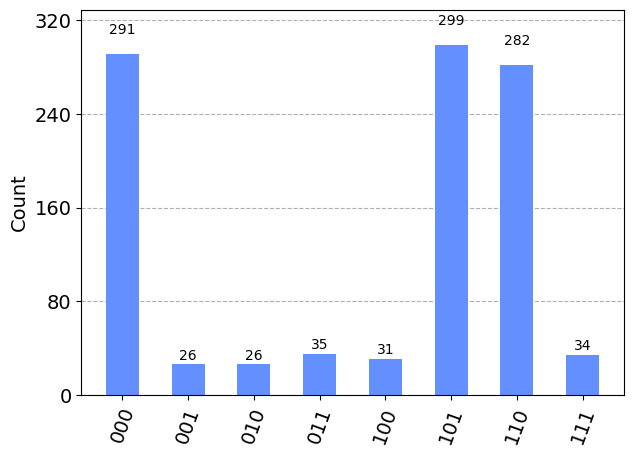

In [7]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())